# Compare results between scipy and legate

When we run pyminiweather on multiple CPUs or GPUs, we get NaNs in the simulation. This creeps up due to result difference between scipy's convolution and legate's convolution implementation (specifically, cuNumeric).

Steps to reproduce:
1. Execute run_cpu.sh script as is.
2. Run this notebook after the simulation completes.
3. Look at the plots below that compare the output from scipy and legate after a convolution operation. In most of the plots below, notice the sharp gradient at x ~ 150:200 and y ~ 100 (indices). This may or may not coincide with the partition interface This difference in results, which was visualized earlier, happens right after the first call to the function `interpolate_z` in pyminiweather/solve.interpolate.py. If we dump the data and read it back and try to reproduce it, we don't see the failure.
4. (optional) Change N_CPUS to 1 in `run_cpus.sh` and run the script, and then run this notebook, to observe that there are no artifacts in and around the partition interface

Possible causes of the bug:
- The inputs to the convolution API are a slice of 3D array and another transformed array (kernel).
- The GPU variant of the convolution implementation could be buggy for these type of input shapes, esp., the kernel

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve
import sys
from typing import List, Any
from pathlib import Path

In [2]:
np.set_printoptions(threshold=sys.maxsize)
cwd = Path("./")

In [3]:
nvariables = 4
nz = 200
nx = 400
hs = 2

In [4]:
save_fig: bool = False

In [5]:
kernel = np.array([-1.0 / 12, 7.0 / 12, 7.0 / 12, -1.0 / 12], dtype=np.float64)

In [6]:
# step_number -> direction
directions = {}

In [7]:
def count_directions(tmp_files: List[str], in_direction: str):
    return sum([in_direction in f.as_posix() for f in tmp_files])

### Read state_forcing files

In [8]:
tmp_files = sorted([file_path for file_path in cwd.glob("*state_forcing.txt")])

n_substeps = len(tmp_files)
state_forcing = np.zeros((n_substeps, nvariables, nz + 2*hs, nx + 2*hs))

for file in tmp_files:
    step, direction, _, _ = file.as_posix().split(".")
    
    step = int(step)
    directions[step] = direction

    # read all files
    state_forcing[step,...] = np.loadtxt(file).reshape(nvariables, nz + 2*hs, nx + 2*hs)

### Read vals files

In [9]:
tmp_files = sorted([file_path for file_path in cwd.glob("*vals.txt")])

# note that the step numbers for vals is local while that of state is global.
# compute offsets to handle the difference in how they are dumped.
# since the bug is reproduced right after the first discrete step, this is 
# not essential for this work

n_substeps = len(tmp_files)

nvals_x = count_directions(tmp_files, ".x.")
nvals_z = count_directions(tmp_files, ".z.")

shape_z = (nvariables, nz + 1, nx)
shape_x = (nvariables, nz, nx + 1)

assert nvals_x + nvals_z == n_substeps

vals_z = np.zeros((nvals_z, *shape_z))
vals_x = np.zeros((nvals_x, *shape_x))

step_z = 0
step_x = 0

for file in tmp_files:
    step, direction, _, _ = file.as_posix().split(".")
    
    if direction == "z":
        vals_z[step_z,...] = np.loadtxt(file).reshape(shape_z)
    elif direction == "x":
        vals_x[step_x,...] = np.loadtxt(file).reshape(shape_x)
        
    if direction == "z":
        step_z += 1
    if direction == "x":
        step_x += 1
    

### Loop over tend files

In [10]:
tend_files = sorted([file_path for file_path in cwd.glob("*tend.txt")])
flux_files = sorted([file_path for file_path in cwd.glob("*flux.txt")])

assert len(tend_files) == len(flux_files)
n_substeps = len(tend_files)

tend = np.zeros((n_substeps, nvariables, nz, nx))
flux = np.zeros((n_substeps, nvariables, nz + 1, nx + 1))
for idx, (tend_file, flux_file) in enumerate(zip(tend_files, flux_files)):
    tend[idx, ...] = np.loadtxt(tend_file).reshape(nvariables, nz, nx)
    flux[idx, ...] = np.loadtxt(flux_file).reshape(nvariables, nz + 1, nx + 1)

### Visualize state_forcing and check if there are any artifacts at the partition interface

In [11]:
step_number = 0
variable_idx = 3 # rhoT

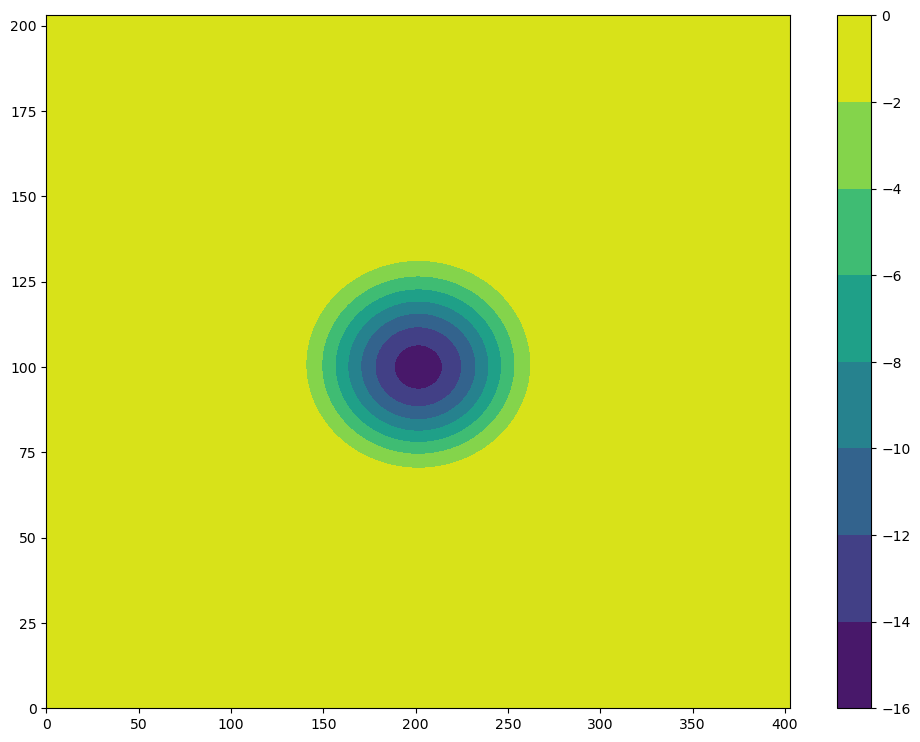

In [12]:
figure = plt.figure(figsize=(12, 9))
h = plt.contourf(state_forcing[step_number][variable_idx])
plt.colorbar(h)
if save_fig:
    plt.savefig("rhoT_initialized.png")

It looks like there are artifacts of partition interface for state as early as step_number: 3, so start do the convolution manually and see if there are any differences. UNtil step 3, we do only convolution in z direction, so check interpolate_z and compute_flux_z

In [13]:
output = convolve(
    state_forcing[step_number][:, :, 2 : nx + 2], 
    kernel[np.newaxis, :, np.newaxis], 
    mode="same",)[:, 2:-1, :]

diff = output[variable_idx] - vals_z[step_number][variable_idx]

print(f"step no: {step_number}, min diff: {diff.min()}, max dirr: {diff.max()}")

step no: 0, min diff: -7.464548985254997, max dirr: 1.2444562867461233


In [14]:
vmin = np.minimum(output.min(), vals_z[step_number].min())
vmax = np.maximum(output.max(), vals_z[step_number].min())

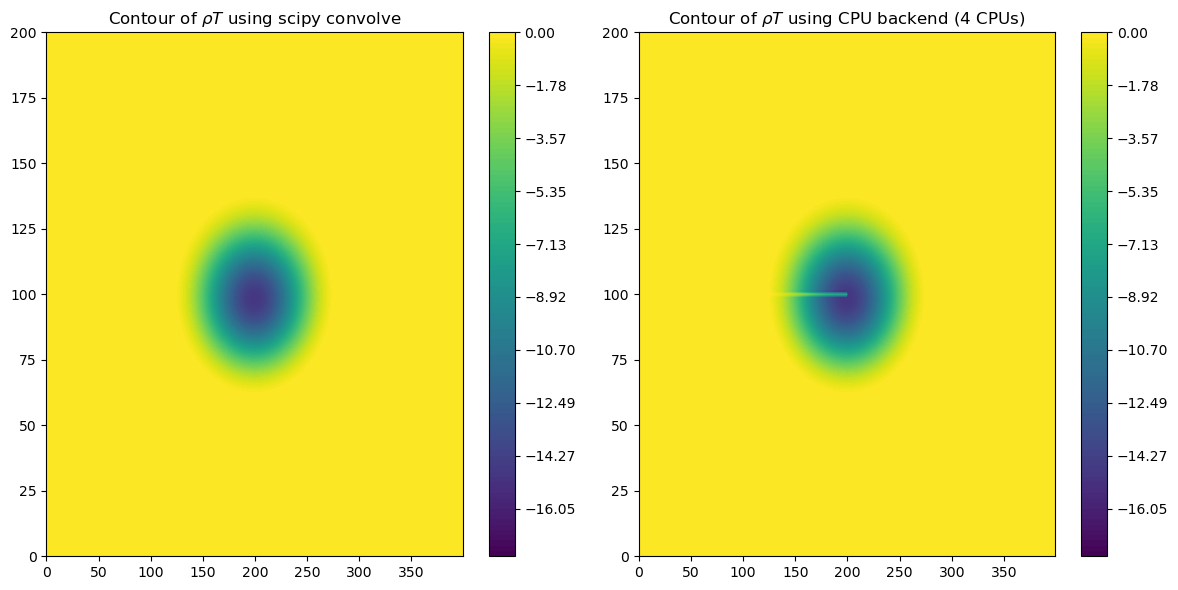

In [15]:
levels = np.linspace(vmin*1.10, vmax*1.10, 100)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

h1 = ax1.contourf(output[variable_idx], levels=levels)
ax1.set_title(r"Contour of $\rho T$ using scipy convolve")

h2 = ax2.contourf(vals_z[step_number][variable_idx], levels=levels)
ax2.set_title(r"Contour of $\rho T$ using CPU backend (4 CPUs)")

cbar1 = fig.colorbar(h1, ax=ax1)
cbar2 = fig.colorbar(h2, ax=ax2)

plt.tight_layout()
if save_fig:
    plt.savefig("rhoT_scipy_legate_comparison.png")

### Plot contours of the difference between scipy and legate

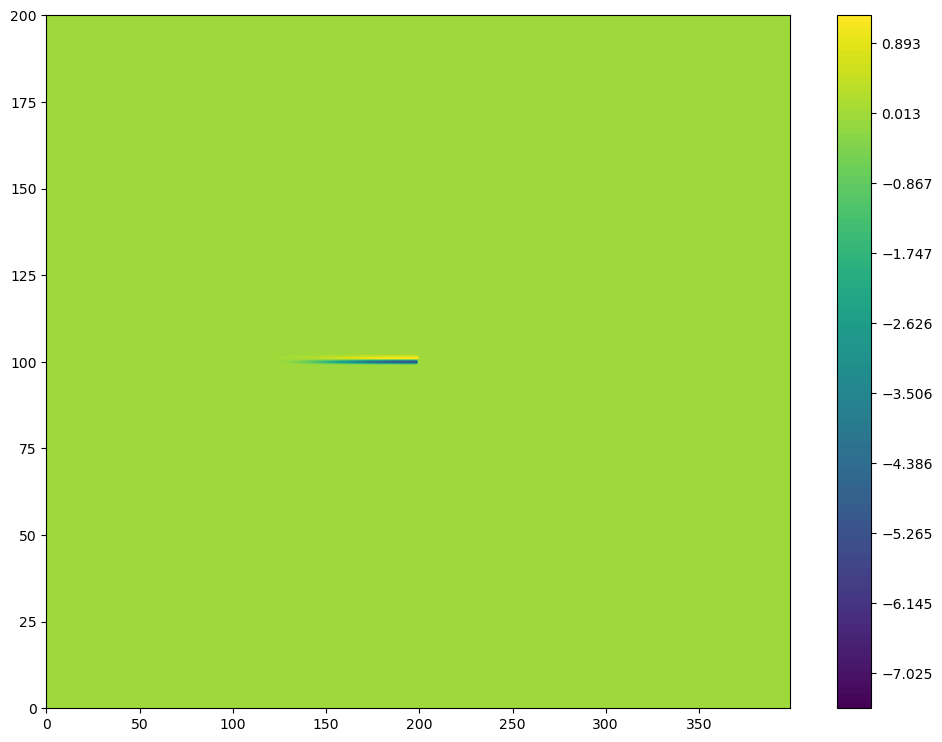

In [16]:
levels = np.linspace(diff.min(), diff.max(), 100)
figure = plt.figure(figsize=(12, 9))
h = plt.contourf(diff, levels=levels)
plt.colorbar(h)
if save_fig:
    plt.savefig("rhoT_difference_scipy_legate.png")

### Visualize tendencies and flux and check for artifacts at partition interface

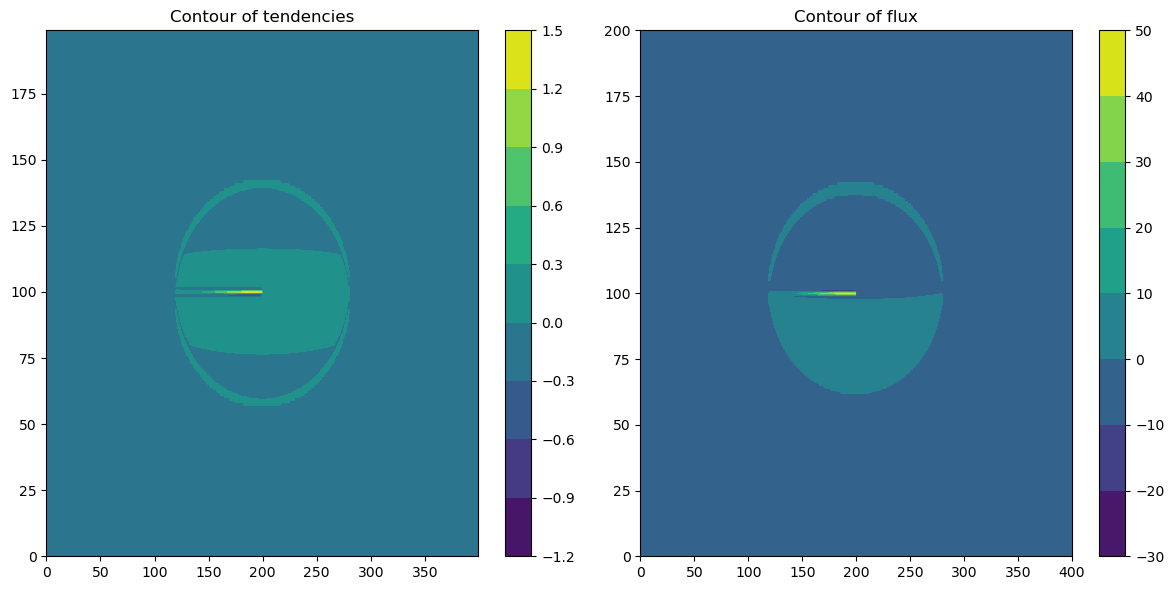

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

h1 = ax1.contourf(tend[step_number][variable_idx])
ax1.set_title(r"Contour of tendencies")

h2 = ax2.contourf(flux[step_number][variable_idx])
ax2.set_title(r"Contour of flux")

cbar1 = fig.colorbar(h1, ax=ax1)
cbar2 = fig.colorbar(h2, ax=ax2)

plt.tight_layout()
if save_fig:
    plt.savefig("tendency_and_flux_legate.png")